### Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from datetime import datetime, timedelta

### Load and Process Data

In [2]:
# Read raw data
df = pd.read_csv('COVID_Russia_2021.csv')
df['Date1'] = pd.to_datetime(df.Date)
df['Date1'] = df['Date1'].dt.strftime('%-m/%-d')
df.head(5)

,Date,Number of new cases,Date1
0,2021-09-02,18985,9/2
1,2021-09-03,18856,9/3
2,2021-09-04,18780,9/4
3,2021-09-05,18645,9/5
4,2021-09-06,17856,9/6


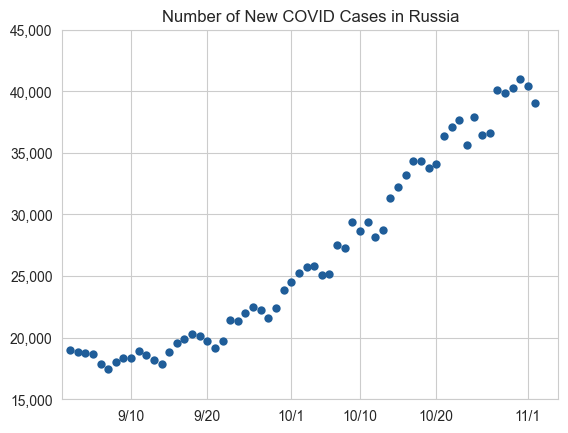

In [3]:
# Plot initial data
sns.set_style("whitegrid")
plt.scatter(df['Date1'], df['Number of new cases'], color = '#1f5d99', alpha=1, linewidth=0.0)
plt.title('Number of New COVID Cases in Russia')
#t = np.arange(pd.to_datetime(df['Date'][0]), pd.to_datetime(df['Date'][len(df)-1]), timedelta(days=10)).astype(datetime)
plt.xticks(['9/10','9/20','10/1','10/10','10/20','11/1'])
plt.yticks(np.arange(15000, 50000, step=5000))
plt.xlim([-1, len(df)+2])
plt.ylim([15000, 45000])
# Add comma separated thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

#plt.savefig("Plots/plot1.png", dpi=400)
plt.show()

### Regression

In [4]:
# Prepare data for regression
x_samp = np.arange(1, len(df)+1, 1, dtype=int)
y_samp = df['Number of new cases'].values
x_lin = np.linspace(0, x_samp.max(), 50)  # a number line, 50 evenly spaced digits between 0 and max

# Define the normal distribution function
def func(x, mu, sigma, scale, offset):
    return offset+scale*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

# Perform regression
p0 = [60, 22, 1200000, 17000] #guessed params
w, _ = opt.curve_fit(func, x_samp, y_samp, p0=p0)
r2 = r2_score(y_samp, func(x_samp, *w))
print("Estimated Parameters", w)
print("R2: ", r2)

Estimated Parameters [6.51111173e+01 2.16114940e+01 1.22951202e+06 1.77734016e+04]
R2:  0.9877176715963988


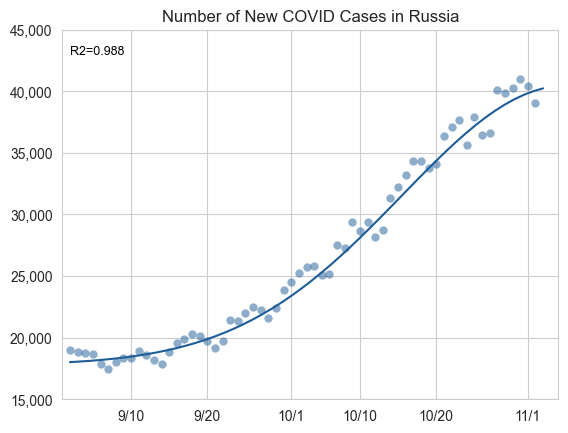

In [5]:
# Plot regression model
y_model = func(x_lin, *w)
plt.plot(x_lin, y_model, color = '#1f5d99', alpha=1)
plt.scatter(df['Date1'], y_samp, color = '#1f5d99', alpha=0.5, linewidth=0.0)
plt.title('Number of New COVID Cases in Russia')
#t = np.arange(pd.to_datetime(df['Date'][0]), pd.to_datetime(df['Date'][len(df)-1]), timedelta(days=10)).astype(datetime)
plt.xticks(['9/10','9/20','10/1','10/10','10/20','11/1'])
plt.yticks(np.arange(15000, 50000, step=5000))
plt.xlim([-1, len(df)+2])
plt.ylim([15000, 45000])
# Add comma separated thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.text(0, 43000, "R2=%.3f" % r2, color='black', fontsize=9, bbox=dict(facecolor='white', edgecolor='white', pad=1))

#plt.savefig("Plots/plot2.png", dpi=400)
plt.show()

In [6]:
# Predict future
x_future = np.arange(0, len(df)+30, step=1)
start_date = np.datetime64(df['Date'][0])
x_future_dates = []
for offset in x_future:
    date = start_date + np.timedelta64(offset)
    x_future_dates.append(date)

x_future_dates_str = [timestamp.astype(datetime).strftime('%-m/%-d') for timestamp in x_future_dates]

y_future = func(x_future, *w)

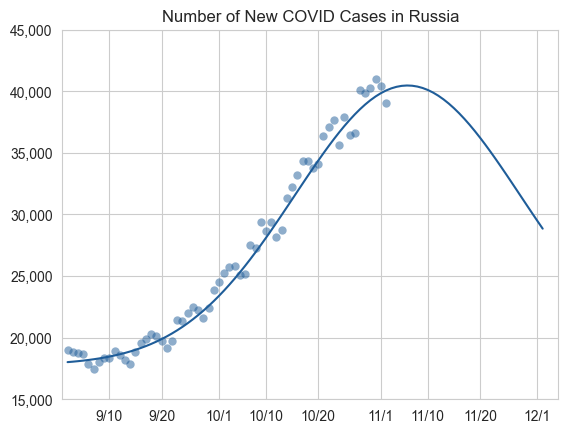

In [7]:
# Plot future prediction

#plt.plot(x_future, y_future, color = '#1f5d99', alpha=1)
plt.plot(x_future_dates_str, y_future, color = '#1f5d99', alpha=1)
plt.scatter(df['Date1'], y_samp, color = '#1f5d99', alpha=0.5, linewidth=0.0)
plt.title('Number of New COVID Cases in Russia')
#t = np.arange(pd.to_datetime(df['Date'][0]), pd.to_datetime(df['Date'][len(df)-1]), timedelta(days=10)).astype(datetime)
plt.xticks(['9/10','9/20','10/1','10/10','10/20','11/1','11/10','11/20','12/1'])
plt.yticks(np.arange(15000, 50000, step=5000))
plt.xlim([-1, len(df)+32])
plt.ylim([15000, 45000])
# Add comma separated thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

#plt.savefig("Plots/plot3.png", dpi=400)
plt.show()

### Compare prediction to actual data

In [8]:
# Read WHO data
# https://covid19.who.int/data
df_who = pd.read_csv('WHO-COVID-19-global-data.csv')
df_who = df_who[df_who['Country_code']=='RU']
df_who.drop(columns=['Country_code','Country','WHO_region','Cumulative_cases','New_deaths','Cumulative_deaths'], inplace=True)
df_who.reset_index(drop=True, inplace=True)
#df_who['Date_reported'] = pd.to_datetime(df_who['Date_reported'])
#df_who['Date_reported'] = df_who['Date_reported'].dt.strftime('%-m/%-d')

# Select dates from Sep 7 to Nov 20
start_index = df_who.loc[df_who['Date_reported'] == df['Date'][0]].index[0]
end_index = start_index + len(df['Date']) + 31
df_who = df_who.iloc[start_index:end_index]
df_who.reset_index(drop=True, inplace=True)

df_who

,Date_reported,New_cases
0,2021-09-02,18985
1,2021-09-03,18856
2,2021-09-04,18780
3,2021-09-05,18645
4,2021-09-06,17856
...,...,...
88,2021-11-29,33860
89,2021-11-30,32648
90,2021-12-01,32837
91,2021-12-02,33389


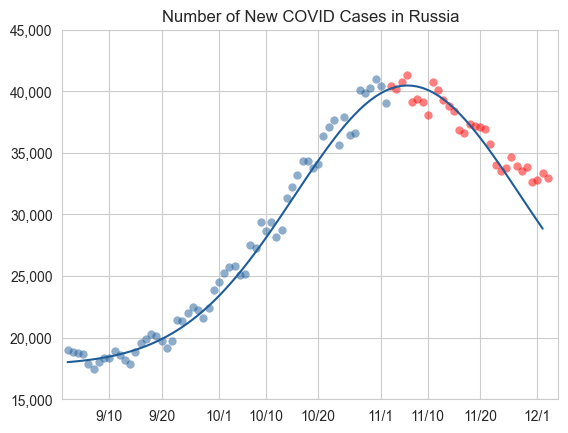

In [9]:
# See how well the prediction worked

plt.plot(x_future_dates_str, y_future, color = '#1f5d99', alpha=1)
plt.scatter(df['Date1'], y_samp, color = '#1f5d99', alpha=0.5, linewidth=0.0)
plt.scatter(range(len(df),len(df_who)), df_who['New_cases'][len(df):], color = 'red', alpha=0.5, linewidth=0.0)
plt.title('Number of New COVID Cases in Russia')
#t = np.arange(pd.to_datetime(df['Date'][0]), pd.to_datetime(df['Date'][len(df)-1]), timedelta(days=10)).astype(datetime)
plt.xticks(['9/10','9/20','10/1','10/10','10/20','11/1','11/10','11/20','12/1'])
plt.yticks(np.arange(15000, 50000, step=5000))
plt.xlim([-1, len(df)+32])
plt.ylim([15000, 45000])
# Add comma separated thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

#plt.savefig("Plots/plot4.png", dpi=400)
plt.show()

In [10]:
# Actual date of maximum
df_who['Date_reported'][df_who['New_cases'].idxmax()]

'2021-11-06'

In [11]:
# Predicted date of maximum
x_future_dates_str[y_future.argmax()]

'11/6'